In [1]:
from metattack import utils
from metattack import meta_gradient_attack as mtk
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.sparse as sp
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

gpu_id = None

In [2]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/mixed_graph_old.npz')
# _A_obs, _X_obs, _z_obs = utils.load_npz('data/making_a_cake_graph.npz')
# _A_obs, _X_obs, _z_obs = utils.load_npz('data/citeseer.npz')
if _X_obs is None:
    _X_obs = sp.eye(_A_obs.shape[0]).tocsr()
    
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)

_A_obs = _A_obs[lcc][:,lcc]
_A_obs.setdiag(0)
_A_obs = _A_obs.astype("float32")
_A_obs.eliminate_zeros()
_X_obs = _X_obs.astype("float32")

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc]
_z_obs = _z_obs[lcc]
_N = _A_obs.shape[0]
_K = _z_obs.max()+1
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,
                                                                       val_size=val_share,
                                                                       test_size=unlabeled_share,
                                                                       stratify=_z_obs)
split_unlabeled = np.union1d(split_val, split_unlabeled)

Selecting 1 largest connected components


c:\Users\fiona\anaconda3\envs\metattack\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
hidden_sizes = [16]
share_perturbations = 0.15
perturbations = int(share_perturbations * (_A_obs.sum()//2))
train_iters = 100
dtype = tf.float32 # change this to tf.float16 if you run out of GPU memory. Might affect the performance and lead to numerical instability

In [5]:
surrogate = mtk.GCNSparse(_A_obs, _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
surrogate.build(with_relu=False)
surrogate.train(split_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
# Predict the labels of the unlabeled nodes to use them for self-training.
labels_self_training = np.eye(_K)[surrogate.logits.eval(session=surrogate.session).argmax(1)]
labels_self_training[split_train] = _Z_obs[split_train]

In [7]:
# The attack variants from the paper
variants = ["Meta-Train", "Meta-Self","A-Meta-Train", "A-Meta-Self", "A-Meta-Both"]
# Choose the variant you would like to try
variant = "Meta-Self"
assert variant in variants

enforce_ll_constrant = False
approximate_meta_gradient = False
if variant.startswith("A-"): # approximate meta gradient
    approximate_meta_gradient = True
    if "Train" in variant:
        lambda_ = 1
    elif "Self" in variant:
        lambda_ = 0
    else:
        lambda_ = 0.5
        
if "Train" in variant:
    idx_attack = split_train
elif "Self" in variant:
    idx_attack = split_unlabeled
else:  # Both
    idx_attack = np.union1d(split_train, split_unlabeled)

In [8]:
if approximate_meta_gradient:
    gcn_attack = mtk.GNNMetaApprox(_A_obs, _X_obs, labels_self_training, hidden_sizes, 
                                   gpu_id=gpu_id, _lambda=lambda_, train_iters=train_iters, dtype=dtype)
else:
    gcn_attack = mtk.GNNMeta(_A_obs, _X_obs.toarray().astype("float32"), labels_self_training, hidden_sizes, 
                             gpu_id=gpu_id, attack_features=False, train_iters=train_iters, dtype=dtype)

In [9]:
gcn_attack.build()
gcn_attack.make_loss(ll_constraint=enforce_ll_constrant)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
if approximate_meta_gradient:
    gcn_attack.attack(perturbations, split_train, split_unlabeled, idx_attack)
else:
    gcn_attack.attack(perturbations, split_train, idx_attack)

In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Now you can use TensorFlow 1.x methods like .eval()
adjacency_changes = gcn_attack.adjacency_changes.eval(session=gcn_attack.session).reshape(_A_obs.shape)
modified_adjacency = gcn_attack.modified_adjacency.eval(session=gcn_attack.session)

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
re_trainings = 20

In [13]:
gcn_before_attack = mtk.GCNSparse(sp.csr_matrix(_A_obs), _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
gcn_before_attack.build(with_relu=True)

In [14]:
accuracies_clean = []
for _it in tqdm(range(re_trainings)):
    gcn_before_attack.train(split_train, initialize=True, display=False)
    accuracy_clean = (gcn_before_attack.logits.eval(session=gcn_before_attack.session).argmax(1) == _z_obs)[split_unlabeled].mean()
    accuracies_clean.append(accuracy_clean)

In [15]:
gcn_after_attack = mtk.GCNSparse(sp.csr_matrix(modified_adjacency), _X_obs, _Z_obs, hidden_sizes, gpu_id=gpu_id)
gcn_after_attack.build(with_relu=True)

In [16]:
accuracies_atk = []
for _it in tqdm(range(re_trainings)):
    gcn_after_attack.train(split_train, initialize=True, display=False)
    accuracy_atk = (gcn_after_attack.logits.eval(session=gcn_after_attack.session).argmax(1) == _z_obs)[split_unlabeled].mean()
    accuracies_atk.append(accuracy_atk)

In [17]:
print(f"accuracies_clean: {accuracies_clean}")
print(f"accuracies_atk: {accuracies_atk}")

accuracies_clean: [0.7652329749103942, 0.7455197132616488, 0.7670250896057348, 0.7383512544802867, 0.7526881720430108, 0.7598566308243727, 0.7741935483870968, 0.7526881720430108, 0.7526881720430108, 0.7562724014336918, 0.7222222222222222, 0.7508960573476703, 0.7526881720430108, 0.7813620071684588, 0.7580645161290323, 0.7670250896057348, 0.7652329749103942, 0.7670250896057348, 0.7849462365591398, 0.7652329749103942]
accuracies_atk: [0.7347670250896058, 0.7598566308243727, 0.7670250896057348, 0.7724014336917563, 0.7598566308243727, 0.7706093189964157, 0.7777777777777778, 0.7652329749103942, 0.7652329749103942, 0.7688172043010753, 0.7544802867383512, 0.7759856630824373, 0.7634408602150538, 0.7831541218637993, 0.7491039426523297, 0.7491039426523297, 0.7634408602150538, 0.7741935483870968, 0.7347670250896058, 0.7634408602150538]


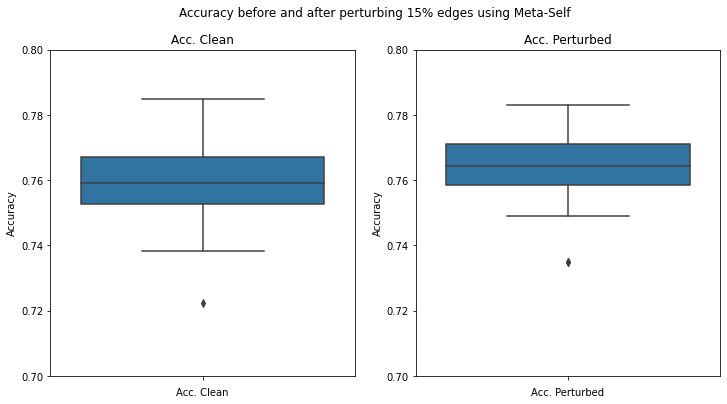

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracies_clean = [0.7652329749103942, 0.7455197132616488, 0.7670250896057348, 0.7383512544802867, 0.7526881720430108, 0.7598566308243727, 0.7741935483870968, 0.7526881720430108, 0.7526881720430108, 0.7562724014336918, 0.7222222222222222, 0.7508960573476703, 0.7526881720430108, 0.7813620071684588, 0.7580645161290323, 0.7670250896057348, 0.7652329749103942, 0.7670250896057348, 0.7849462365591398, 0.7652329749103942]
accuracies_atk = [0.7347670250896058, 0.7598566308243727, 0.7670250896057348, 0.7724014336917563, 0.7598566308243727, 0.7706093189964157, 0.7777777777777778, 0.7652329749103942, 0.7652329749103942, 0.7688172043010753, 0.7544802867383512, 0.7759856630824373, 0.7634408602150538, 0.7831541218637993, 0.7491039426523297, 0.7491039426523297, 0.7634408602150538, 0.7741935483870968, 0.7347670250896058, 0.7634408602150538]

# Create two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot boxplot for accuracies_clean
sns.boxplot(ax=axs[0], y=accuracies_clean)
axs[0].set_title("Acc. Clean")
axs[0].set_ylim([0.7, 0.8])  # Set the y-axis range to be from 0 to 0.5

# Plot boxplot for accuracies_atk
sns.boxplot(ax=axs[1], y=accuracies_atk)
axs[1].set_title("Acc. Perturbed")
axs[1].set_ylim([0.7, 0.8])  # Set the y-axis range to be from 0 to 0.5

# Set labels for y-axis
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Accuracy")

# Set labels for x-axis
axs[0].set_xlabel("Acc. Clean")
axs[1].set_xlabel("Acc. Perturbed")

# Set overall title
plt.suptitle(f"Accuracy before and after perturbing {int(share_perturbations*100)}% edges using {variant}")

# Save the figure
plt.savefig("example.png", dpi=600)
plt.savefig("example.svg")

# Display the plot
plt.show()
